In [2]:
import pandas as pd
import numpy as np
import torch
from torchcast.kalman_filter import KalmanFilter

from torchcast.process import LocalTrend, Season
from torchcast.utils.data import TimeSeriesDataset

In [3]:
def extract_time_series_cats(df, cat):
    new_df = df[df['Item Name'].str.contains(cat, case=False)]
    day_df = new_df.groupby('date').agg(quantity = ('Quantity', 'sum'))
    day_df = day_df.reset_index()
    day_df.rename(columns = {'quantity': f'{item.replace(" ", "")}Quantity'}, inplace=True)
    day_df['date'] = pd.to_datetime(day_df['date'])
    return day_df

In [4]:
cats = ['Chicken', 'Lamb', 'Prawn', 'Naan']

In [5]:
df = pd.read_pickle('data/restaurant/processed1.pkl')
multi_df1 = pd.DataFrame()
multi_df1['date'] = pd.date_range(start = "2016-07-18", end = "2019-08-03")
for item in cats:
    tmp_df = extract_time_series_cats(df, item)
    multi_df1 = pd.merge(multi_df1, tmp_df, on='date', how='outer')
multi_df1 = multi_df1.fillna(0)
multi_df1 = multi_df1.sort_values('date')
multi_df1 = multi_df1.reset_index()

In [6]:
df2 = pd.read_pickle('data/restaurant/processed1.pkl')
multi_df2 = pd.DataFrame()
multi_df2['date'] = pd.date_range(start = "2016-07-18", end = "2019-08-03")
for item in cats:
    tmp_df = extract_time_series_cats(df2, item)
    multi_df2 = pd.merge(multi_df2, tmp_df, on='date', how='outer')
multi_df2 = multi_df2.fillna(0)
multi_df2 = multi_df2.sort_values('date')
multi_df2 = multi_df2.reset_index()

In [7]:
if 'index' in multi_df1.columns.tolist(): 
    multi_df1 = multi_df1.drop(columns=['index'])
if 'index' in multi_df2.columns.tolist(): 
    multi_df2 = multi_df2.drop(columns=['index'])

In [8]:
multi_df1['restaurant'] = [1]*len(multi_df1)
multi_df2['restaurant'] = [2]*len(multi_df2)

In [9]:
# Create datasets (Might need to normalize)
time_ds1 = TimeSeriesDataset.from_dataframe(
    dataframe=multi_df1,
    dt_unit='D',
    measure_colnames=multi_df1.columns.tolist()[1:-1],
    group_colname='restaurant',
    time_colname='date'
)

time_ds2 = TimeSeriesDataset.from_dataframe(
    dataframe=multi_df2,
    dt_unit='D',
    measure_colnames=multi_df2.columns.tolist()[1:-1],
    group_colname='restaurant',
    time_colname='date'
)

split_time = pd.to_datetime('2018-12-24')
ds1_train, ds1_val = time_ds1.train_val_split(dt=split_time)
ds2_train, ds2_val = time_ds2.train_val_split(dt=split_time)

In [10]:
# Setup model
processes = []
for m in ds1_train.measures[0]:
    processes.extend([
        LocalTrend(id=f'{m}_trend', measure=m),
        Season(id=f'{m}_day_of_week', period=7, dt_unit='D', K=3, measure=m, fixed=True),
        Season(id=f'{m}_day_of_year', period=365.25, dt_unit='D', K=6, measure=m, fixed=True)
    ])
kf = KalmanFilter(measures=ds1_train.measures[0], processes=processes)

In [12]:
kf.fit(
    ds1_train.tensors[0],
    max_iter=50,
    n_step=7,
    every_step=False,
    start_offsets=ds1_train.start_datetimes
)

  0%|          | 0/12 [00:00<?, ?it/s]

KalmanFilter(processes=[LocalTrend(id='ChickenQuantity_trend'), Season(id='ChickenQuantity_day_of_week'), Season(id='ChickenQuantity_day_of_year'), LocalTrend(id='LambQuantity_trend'), Season(id='LambQuantity_day_of_week'), Season(id='LambQuantity_day_of_year'), LocalTrend(id='PrawnQuantity_trend'), Season(id='PrawnQuantity_day_of_week'), Season(id='PrawnQuantity_day_of_year'), LocalTrend(id='NaanQuantity_trend'), Season(id='NaanQuantity_day_of_week'), Season(id='NaanQuantity_day_of_year')], measures=['ChickenQuantity', 'LambQuantity', 'PrawnQuantity', 'NaanQuantity'])

In [13]:
pred = kf(
        ds1_train.tensors[0],
        start_offsets=ds1_train.start_datetimes,
        out_timesteps=time_ds1.tensors[0].shape[1]
)

loss = -pred.log_prob(ds1_train.tensors[0]).mean()
print(loss)

tensor(10.2437, grad_fn=<NegBackward0>)


In [14]:
df_pred = pred.to_dataframe(time_ds1, multi=None)
df_pred

,actual,group,mean,measure,std,time
0,0.0,1,5.418762,ChickenQuantity,23.693186,2016-07-18
1,3.0,1,-0.683769,ChickenQuantity,10.832267,2016-07-19
2,3.0,1,3.947540,ChickenQuantity,7.823967,2016-07-20
3,12.0,1,-2.181949,ChickenQuantity,8.348081,2016-07-21
4,12.0,1,19.036606,ChickenQuantity,7.829011,2016-07-22
...,...,...,...,...,...,...
1107,9.0,1,7.552555,NaanQuantity,5.329428,2019-07-30
1108,13.0,1,8.231240,NaanQuantity,5.325695,2019-07-31
1109,7.0,1,8.993924,NaanQuantity,5.332514,2019-08-01
1110,15.0,1,16.362055,NaanQuantity,5.326896,2019-08-02


/home/21651388/anaconda3/envs/HackathonTakeAway/lib/python3.10/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


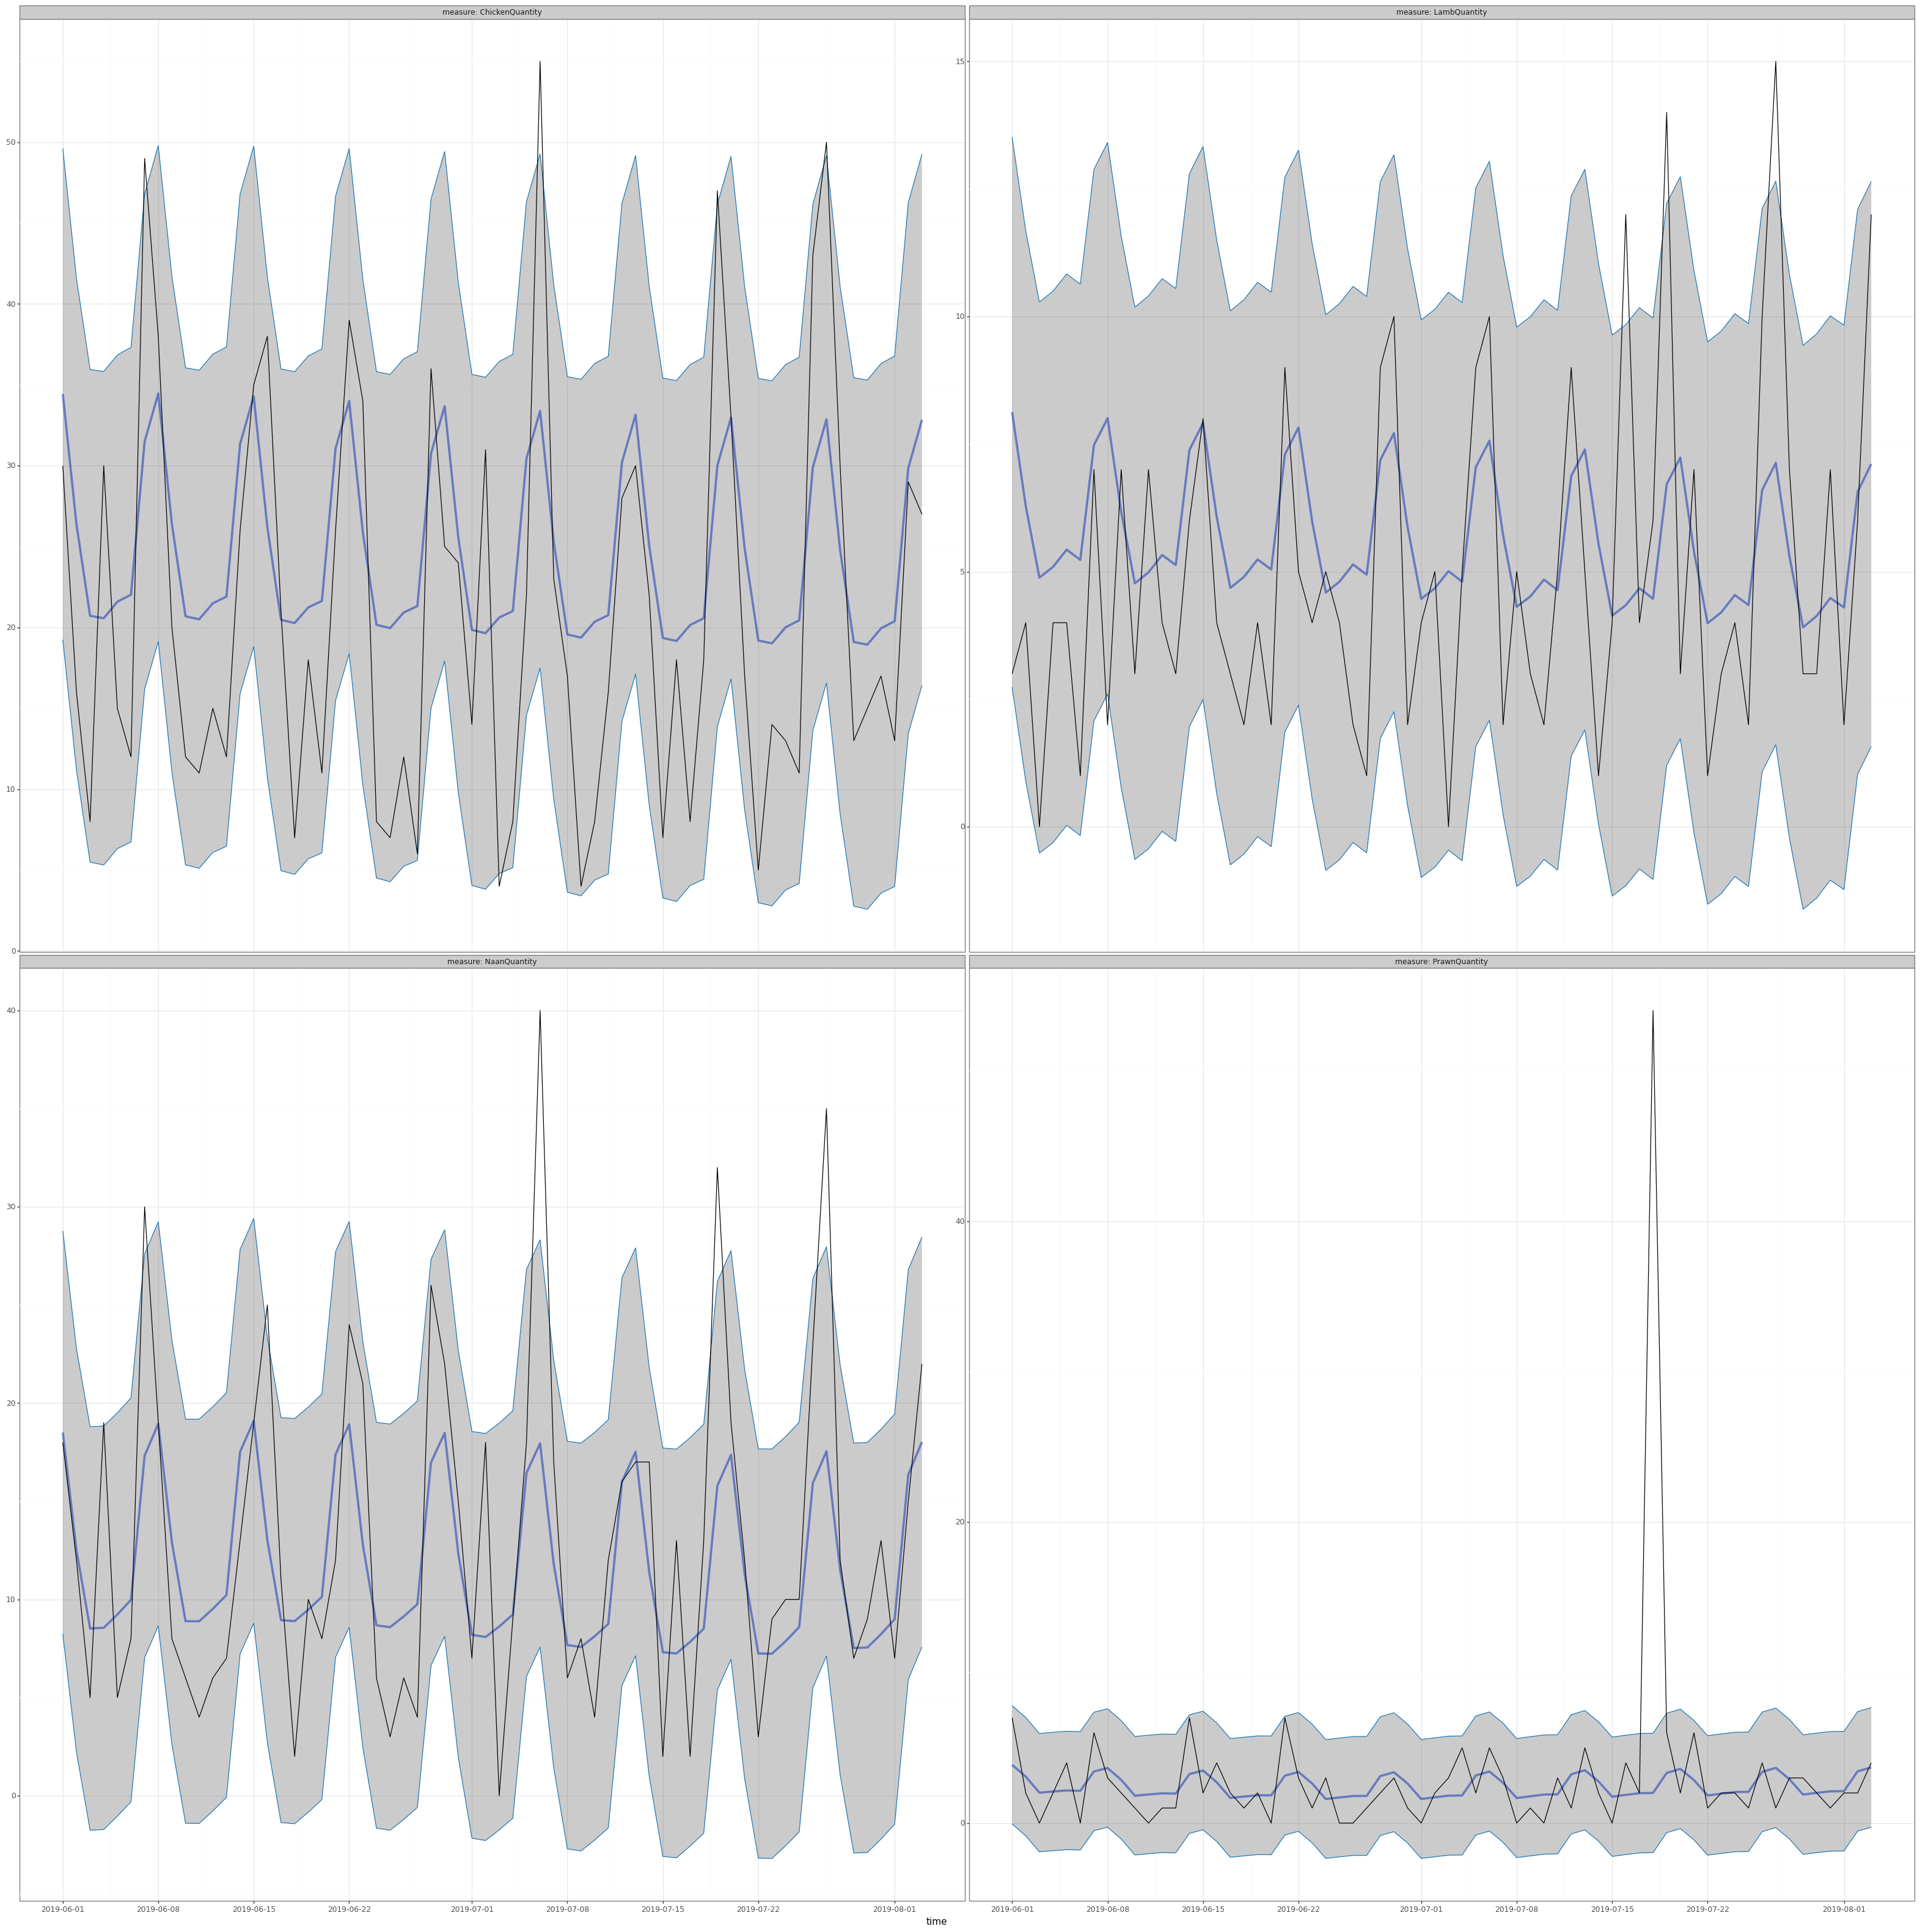

In [26]:
print(pred.plot(df_pred.query("group==1 & time.dt.year==2019 & time.dt.month>=6"), figure_size=(40, 40)))

In [16]:
val_df_pred = df_pred.query("time>@split_time")
val_df_pred = val_df_pred.reset_index()
if 'index' in val_df_pred.columns.tolist(): 
    val_df_pred = val_df_pred.drop(columns=['index'])

In [17]:
total_df = val_df_pred.groupby('time').agg(predict = ('mean', 'sum'), true = ('actual', 'sum'))
total_df = total_df.reset_index()
if 'index' in total_df.columns.tolist(): 
    total_df = total_df.drop(columns=['index'])
chicken_df = val_df_pred[val_df_pred['measure'] == 'ChickenQuantity']
lamb_df = val_df_pred[val_df_pred['measure'] == 'LambQuantity']
prawn_df = val_df_pred[val_df_pred['measure'] == 'PrawnQuantity']
naan_df = val_df_pred[val_df_pred['measure'] == 'NaanQuantity']

In [18]:
total_rmse = ((val_df_pred['mean'] - val_df_pred['actual']) ** 2).mean() ** .5
total_rmse2 = ((total_df['predict'] - total_df['true']) ** 2).mean() ** .5
chicken_rmse = ((chicken_df['mean'] - chicken_df['actual']) ** 2).mean() ** .5
lamb_rmse = ((lamb_df['mean'] - lamb_df['actual']) ** 2).mean() ** .5
prawn_rmse = ((prawn_df['mean'] - prawn_df['actual']) ** 2).mean() ** .5
naan_rmse = ((naan_df['mean'] - naan_df['actual']) ** 2).mean() ** .5

rmse_df = pd.DataFrame({'Category': ['Total', 'Total2', 'Chicken', 'Lamb', 'Prawn', 'Naan'],
                   'RMSE': [total_rmse, total_rmse2, chicken_rmse, lamb_rmse, prawn_rmse, naan_rmse]})

In [19]:
rmse_df

,Category,RMSE
0,Total,6.793800
1,Total2,19.178126
2,Chicken,10.569746
3,Lamb,3.214666
4,Prawn,3.975719
5,Naan,6.838344


In [27]:
# Setup model
processes = []
for m in ds2_train.measures[0]:
    processes.extend([
        LocalTrend(id=f'{m}_trend', measure=m),
        Season(id=f'{m}_day_of_week', period=7, dt_unit='D', K=3, measure=m, fixed=True),
        Season(id=f'{m}_day_of_year', period=365.25, dt_unit='D', K=6, measure=m, fixed=True)
    ])
kf = KalmanFilter(measures=ds2_train.measures[0], processes=processes)

In [28]:
kf.fit(
    ds2_train.tensors[0],
    max_iter=50,
    n_step=7,
    every_step=False,
    start_offsets=ds2_train.start_datetimes
)

  0%|          | 0/12 [00:00<?, ?it/s]

KalmanFilter(processes=[LocalTrend(id='ChickenQuantity_trend'), Season(id='ChickenQuantity_day_of_week'), Season(id='ChickenQuantity_day_of_year'), LocalTrend(id='LambQuantity_trend'), Season(id='LambQuantity_day_of_week'), Season(id='LambQuantity_day_of_year'), LocalTrend(id='PrawnQuantity_trend'), Season(id='PrawnQuantity_day_of_week'), Season(id='PrawnQuantity_day_of_year'), LocalTrend(id='NaanQuantity_trend'), Season(id='NaanQuantity_day_of_week'), Season(id='NaanQuantity_day_of_year')], measures=['ChickenQuantity', 'LambQuantity', 'PrawnQuantity', 'NaanQuantity'])

In [29]:
pred = kf(
        ds2_train.tensors[0],
        start_offsets=ds2_train.start_datetimes,
        out_timesteps=time_ds2.tensors[0].shape[1]
)

loss = -pred.log_prob(ds2_train.tensors[0]).mean()
print(loss)

tensor(10.2414, grad_fn=<NegBackward0>)


In [30]:
df_pred = pred.to_dataframe(time_ds2, multi=None)
df_pred

,actual,group,mean,measure,std,time
0,0.0,1,5.416445,ChickenQuantity,20.610468,2016-07-18
1,3.0,1,-0.136623,ChickenQuantity,8.699525,2016-07-19
2,3.0,1,2.217435,ChickenQuantity,7.800470,2016-07-20
3,12.0,1,-2.779966,ChickenQuantity,7.625221,2016-07-21
4,12.0,1,13.557764,ChickenQuantity,7.106024,2016-07-22
...,...,...,...,...,...,...
1107,9.0,1,7.873457,NaanQuantity,5.364241,2019-07-30
1108,13.0,1,8.406670,NaanQuantity,5.360632,2019-07-31
1109,7.0,1,9.133884,NaanQuantity,5.369089,2019-08-01
1110,15.0,1,16.576986,NaanQuantity,5.362522,2019-08-02


/home/21651388/anaconda3/envs/HackathonTakeAway/lib/python3.10/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


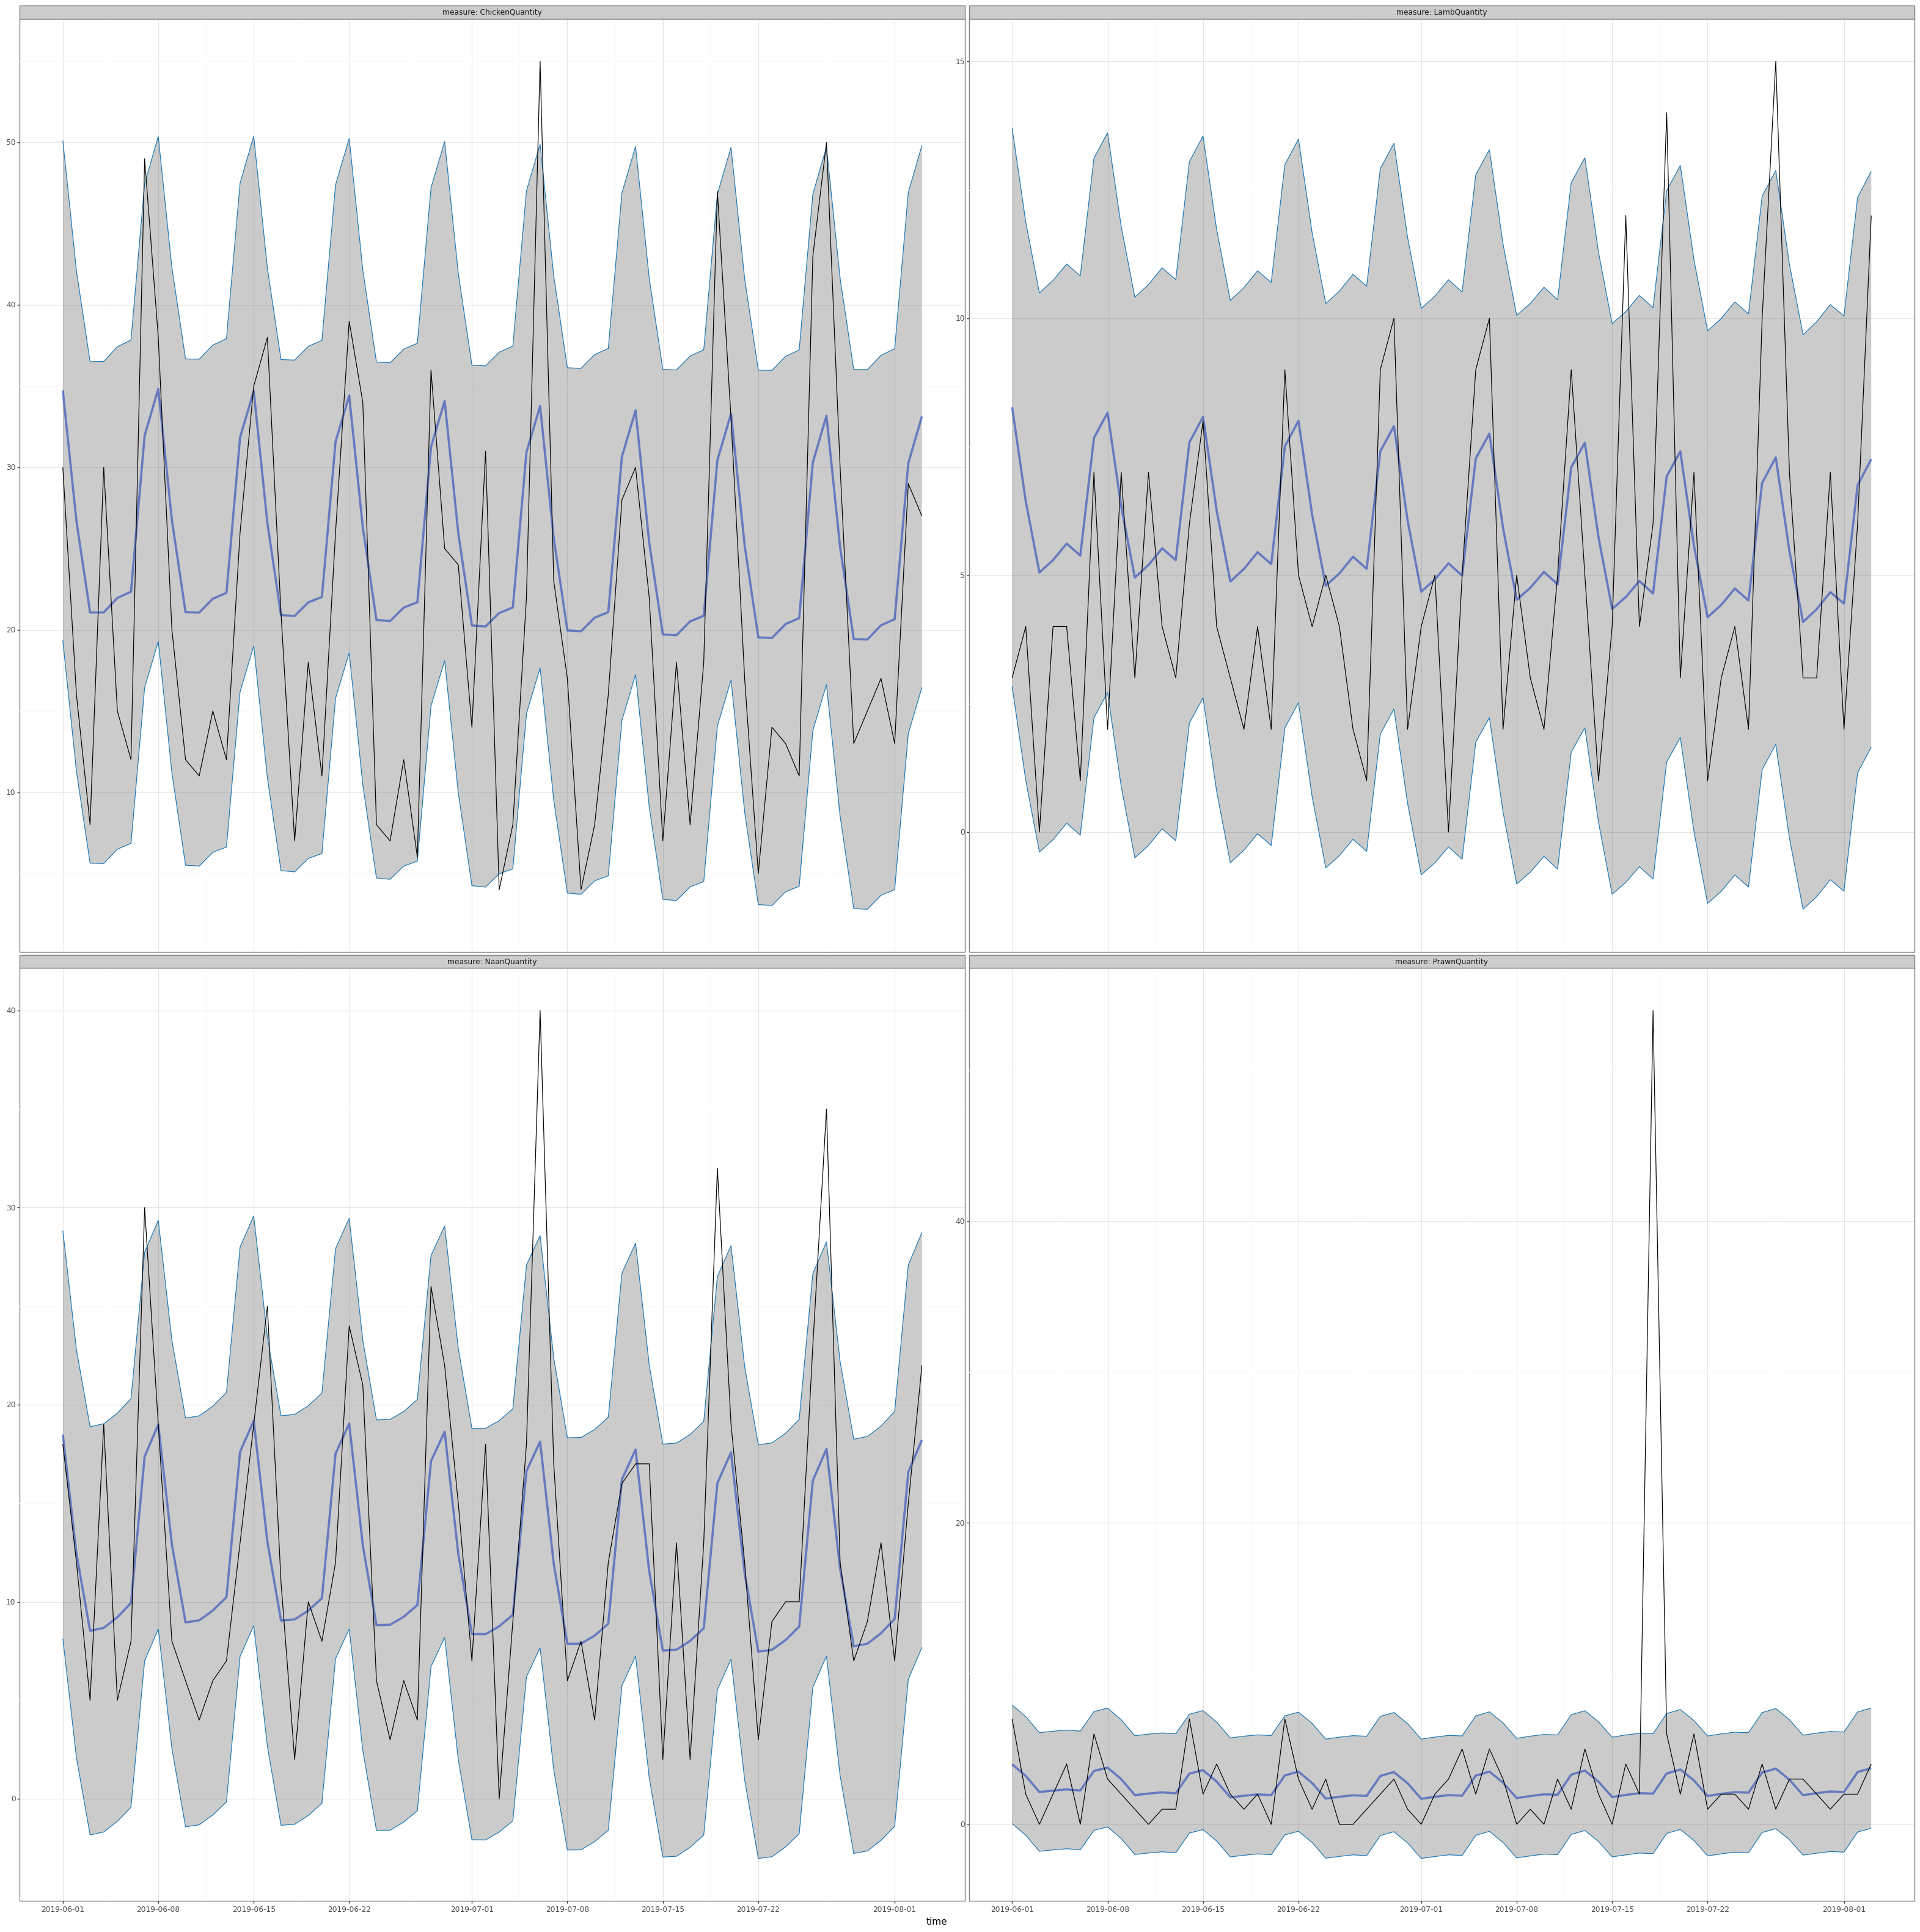

In [31]:
print(pred.plot(df_pred.query("group==1 & time.dt.year==2019 & time.dt.month>=6"), figure_size=(40, 40)))

In [32]:
val_df_pred = df_pred.query("time>@split_time")
val_df_pred = val_df_pred.reset_index()
if 'index' in val_df_pred.columns.tolist(): 
    val_df_pred = val_df_pred.drop(columns=['index'])

In [33]:
total_df = val_df_pred.groupby('time').agg(predict = ('mean', 'sum'), true = ('actual', 'sum'))
total_df = total_df.reset_index()
if 'index' in total_df.columns.tolist(): 
    total_df = total_df.drop(columns=['index'])
chicken_df = val_df_pred[val_df_pred['measure'] == 'ChickenQuantity']
lamb_df = val_df_pred[val_df_pred['measure'] == 'LambQuantity']
prawn_df = val_df_pred[val_df_pred['measure'] == 'PrawnQuantity']
naan_df = val_df_pred[val_df_pred['measure'] == 'NaanQuantity']

In [34]:
total_rmse = ((val_df_pred['mean'] - val_df_pred['actual']) ** 2).mean() ** .5
total_rmse2 = ((total_df['predict'] - total_df['true']) ** 2).mean() ** .5
chicken_rmse = ((chicken_df['mean'] - chicken_df['actual']) ** 2).mean() ** .5
lamb_rmse = ((lamb_df['mean'] - lamb_df['actual']) ** 2).mean() ** .5
prawn_rmse = ((prawn_df['mean'] - prawn_df['actual']) ** 2).mean() ** .5
naan_rmse = ((naan_df['mean'] - naan_df['actual']) ** 2).mean() ** .5

rmse_df = pd.DataFrame({'Category': ['Total', 'Total2', 'Chicken', 'Lamb', 'Prawn', 'Naan'],
                   'RMSE': [total_rmse, total_rmse2, chicken_rmse, lamb_rmse, prawn_rmse, naan_rmse]})

In [35]:
rmse_df

,Category,RMSE
0,Total,6.822475
1,Total2,19.240192
2,Chicken,10.631162
3,Lamb,3.226536
4,Prawn,3.979783
5,Naan,6.849365
